In [2]:
from skimage import exposure
import cv2
import numpy as np
import matplotlib.pyplot as plt


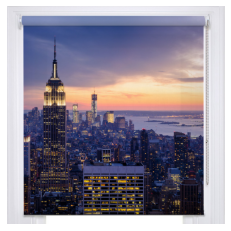

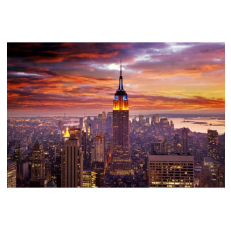

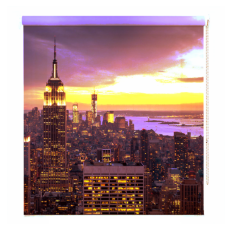

In [3]:
# show image function
def show(image):
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

# load the source and reference images
src = cv2.imread("/content/drive/MyDrive/colab_img/histogram_matching_srx.jfif")
ref = cv2.imread("/content/drive/MyDrive/colab_img/histogram_matching_ref.jpg")
show(src)
show(ref)
# determine if we are performing multichanel histogram matching and then
# perform histogram matching itself
multi = True if src.shape[-1] > 1 else False
matched = exposure.match_histograms(src, ref, multichannel=multi)


show(matched)

In [4]:
def image_stats(image):
  #compute the mean and standard deviation of each channel
  l, a, b = cv2.split(image)
  lMean, lStd = l.mean(), l.std()
  aMean, aStd = a.mean(), a.std()
  bMean, bStd = b.mean(), b.std()

  return lMean, lStd, aMean, aStd, bMean, bStd

def color_tranfer(src, ref):
  src = cv2.cvtColor(src, cv2.COLOR_BGR2LAB).astype(np.float32)
  ref = cv2.cvtColor(ref, cv2.COLOR_BGR2LAB).astype(np.float32)

  lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc = image_stats(ref)
  lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar = image_stats(src)

  l,a,b = cv2.split(src)
  l-=lMeanTar
  a-=aMeanTar
  b-=bMeanTar

  l = (lStdTar / lStdSrc) * l
  a = (aStdTar / aStdSrc) * a
  b = (bStdTar / bStdSrc) * b

  l += lMeanSrc
  a += aMeanSrc
  b += bMeanSrc

  l = np.clip(l, 0, 255)
  a = np.clip(a, 0, 255)
  b = np.clip(b, 0, 255)

  tranfer = cv2.merge([l,a,b]).astype(np.uint8)
  tranfer = cv2.cvtColor(tranfer, cv2.COLOR_LAB2BGR)
  return tranfer

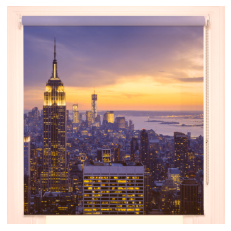

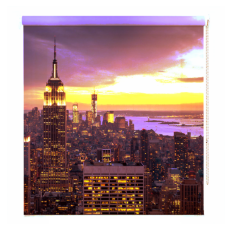

In [5]:
tranfer = color_tranfer(src,ref)
show(tranfer)
show(matched)

In [ ]:

# construct a figure to display the histogram plots for each channel before and
# after histogram matching was applied
fig, axs = plt.subplots(nrows=3, ncols=3, figsize(8,8))

# loop over our source image, reference image, and output matched image
for i, image in enumerate((src, ref, matched)):
  # convert the image from BGR to RGB channel ordering
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # loop over the names of the channel in RGB color
  for j, color in enumerate(("red","green","blue")):
    # image[..., j] == image[:,:,j]
    hist, bin = exposure.histogram(image[..., j], source_range="dtype")
    axs[j,i].plot(bins, hist/hist.max())

    # compute the cumulative distribution function for the current channel and 
    # plot it
    cdf, bins = exposure.cumulative_distribution(image[..., j])
    axs[j,i].plot(bins, cdf)

    # set the y-axis label of the current plot to be the name of the current 
    # color channel
    axs[j,0].set_ylabel(color)

# set the axes titles
axs[0, 0].set_title("Source")
axs[0, 1].set_title("Reference")
axs[0, 2].set_title("Matched")

plt.tight_layout()
plt.show()